In [31]:
!pip install torch torchvision

In [32]:
#Import Libraries


from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
mnist = torchvision.datasets.MNIST('/files/', download=True)

In [33]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False

In [34]:
#load the data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

In [36]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [37]:
example_data.shape

torch.Size([1000, 1, 28, 28])

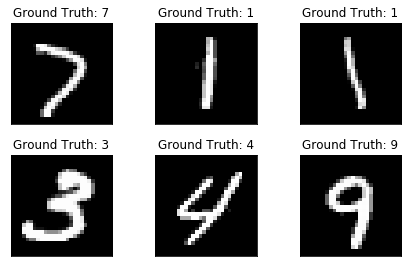

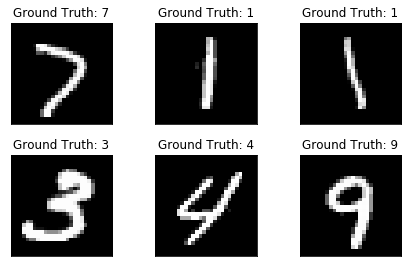

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [39]:

class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)

In [53]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10)]

In [54]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    train_losses.append(loss.item())
    train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [55]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348254
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.305703
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.282516
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.280544
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.257468
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.242146


C:\Users\plk1544\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\plk1544\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.1875, Accuracy: 4841/10000 (48%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.214809
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.189556
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.137943
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.080223
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.010799
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.901058

Test set: Average loss: 1.5437, Accuracy: 7536/10000 (75%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.762951
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.621582
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.509804
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.337913
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.269364
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.186102

Test set: Average loss: 0.7175, Accuracy: 8563/10000 (85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.159729
Train Epoch: 4 [10000/60000 (17%)]	Loss: 1.046785
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.000885
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.998453
Train Epoch: 4 [40000/60000 (67%

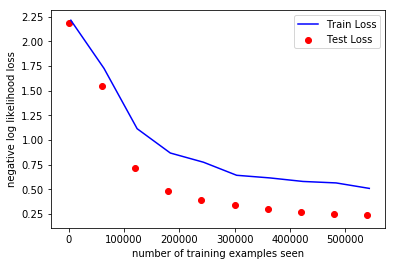

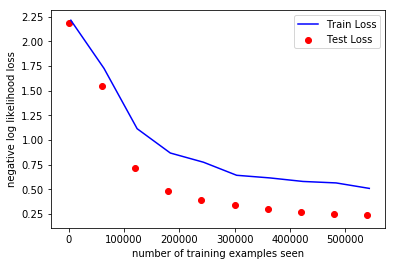

In [56]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig